In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
import matplotlib.pylab as plt
import pickle
import sys
import os
from PIL import Image

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Data generator parameters
gen_params = {"featurewise_center":False,\
              "samplewise_center":False,\
              "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,\
              "zca_whitening":False,\
              "rotation_range":20,\
              "width_shift_range":0.1,\
              "height_shift_range":0.1, \
              "shear_range":0.2, \
              "zoom_range":0.1,\
              "horizontal_flip":True,\
              "vertical_flip":True}

# Train and validation generators
train_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
val_gen = ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

class_names = ["Black", "Blue",  "Green", "Take-to-recycle"]

bs = 64 # batch size

train_generator = train_gen.flow_from_directory(
    directory = "/Users/mac/Desktop/ENEL645/Final Project/Garbage-dataset-pre-processed/Train",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

validation_generator = val_gen.flow_from_directory(
    directory = "/Users/mac/Desktop/ENEL645/Final Project/Garbage-dataset-pre-processed/Validation",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",)

Found 5139 images belonging to 4 classes.
Found 1123 images belonging to 4 classes.


In [3]:
# model_name_it = "garbage_classifier_mn_50_it.h5"
# model_name_ft = "garbage_classifier_mn_50_ft.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)


# monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
#                                              verbose=0,save_best_only=True,\
#                                              save_weights_only=False,\
#                                              mode='min')

# monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
#                                              verbose=0,save_best_only=True,\
#                                              save_weights_only=False,\
#                                              mode='min')

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)


def define_callbacks(model_name_it, model_name_ft ):
  # model_name_it = "garbage_classifier_vgg19_it.h5"
  # model_name_ft = "garbage_classifier_vgg19_ft.h5"

    monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                                  verbose=0,save_best_only=True,\
                                                  save_weights_only=False,\
                                                  mode='min')
    monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',\
                                                  verbose=0,save_best_only=True,\
                                                  save_weights_only=False,\
                                                  mode='min')
    return monitor_it, monitor_ft






In [4]:
monitor_it0, monitor_ft0 = define_callbacks("garbage_classifier_mn_freez_it.h5",  "garbage_classifier_mn_freez_ft.h5")
monitor_it1, monitor_ft1 = define_callbacks("garbage_classifier_mn_ufreez_it.h5",  "garbage_classifier_mn_ufreez_ft.h5")


In [5]:
# img_height = 224
# img_width = 224

# # Defining the model
# base_model = tf.keras.applications.MobileNet(
#     weights='imagenet',  # Load weights pre-trained on ImageNet.
#     input_shape=(img_height, img_width, 3),
#     include_top=False) 
# base_model.trainable = False

# x1 = base_model(base_model.input, training = False)
# x2 = tf.keras.layers.Flatten()(x1)


# out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
# model = tf.keras.Model(inputs = base_model.input, outputs =out)

# print("Initial Training Model")
# print(model.summary())

def build_model(class_names, training):
    
    img_height = 256
    img_width = 256
    
    # Defining the model
    base_model = tf.keras.applications.MobileNet(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = training
    x1 = base_model(base_model.input, training = training)
    x2 = tf.keras.layers.Flatten()(x1)
    out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = base_model.input, outputs =out)
    
    print("--------------------------------------------------------")
    print("Initial Training Model: ")
    print("Training: ", training)
    print(model.summary())
    return model

In [6]:
model0 = build_model(class_names, False)
model1 = build_model(class_names, True)

Metal device set to: Apple M1 Max


2022-04-03 12:57:27.344455: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-03 12:57:27.344627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


--------------------------------------------------------
Initial Training Model: 
Training:  False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4)                 262148    
                                                                 
Total params: 3,491,012
Trainable params: 262,148
Non-trainable params: 3,228,864
_________________________________________________________________
None
-------

In [8]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# history_it = model.fit(train_generator, epochs=10, verbose = 1, \
#                        callbacks= [early_stop, monitor_it, lr_schedule], \
#                        validation_data = (validation_generator))

def fit_it_model(monitor_it, model, epochs):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    history_it = model.fit(train_generator, epochs=epochs, verbose = 1, \
                        callbacks= [early_stop, monitor_it, lr_schedule], \
                        validation_data = (validation_generator))
    return history_it



In [9]:
history_it0 = fit_it_model(monitor_it0, model0, 50)
history_it1 = fit_it_model(monitor_it1, model1, 50)

2022-04-03 12:58:27.539443: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-04-03 12:58:27.932477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 0.9145 - accuracy: 0.7128

2022-04-03 12:59:06.184874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 47s 575ms/step - loss: 0.9145 - accuracy: 0.7128 - val_loss: 0.9588 - val_accuracy: 0.7355 - lr: 1.0000e-04
Epoch 2/50
81/81 [==============================] - 46s 570ms/step - loss: 0.5944 - accuracy: 0.8070 - val_loss: 0.7665 - val_accuracy: 0.7738 - lr: 1.0000e-04
Epoch 3/50
81/81 [==============================] - 46s 562ms/step - loss: 0.4631 - accuracy: 0.8453 - val_loss: 0.8110 - val_accuracy: 0.7711 - lr: 1.0000e-04
Epoch 4/50
81/81 [==============================] - 46s 566ms/step - loss: 0.4196 - accuracy: 0.8583 - val_loss: 0.7497 - val_accuracy: 0.7845 - lr: 1.0000e-04
Epoch 5/50
81/81 [==============================] - 46s 569ms/step - loss: 0.3651 - accuracy: 0.8745 - val_loss: 0.7213 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/50
81/81 [==============================] - 46s 570ms/step - loss: 0.3503 - accuracy: 0.8774 - val_loss: 0.7518 - val_accuracy: 0.7898 - lr: 1.0000e-04
Epoch 7/50
81/81 [==============================] -

2022-04-03 13:23:28.493444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 0.9792 - accuracy: 0.7245

2022-04-03 13:24:10.679214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 53s 619ms/step - loss: 0.9792 - accuracy: 0.7245 - val_loss: 0.9518 - val_accuracy: 0.7355 - lr: 1.0000e-04
Epoch 2/50
81/81 [==============================] - 47s 581ms/step - loss: 0.5970 - accuracy: 0.8290 - val_loss: 0.8441 - val_accuracy: 0.7863 - lr: 1.0000e-04
Epoch 3/50
81/81 [==============================] - 47s 583ms/step - loss: 0.4576 - accuracy: 0.8595 - val_loss: 0.8952 - val_accuracy: 0.7747 - lr: 1.0000e-04
Epoch 4/50
81/81 [==============================] - 47s 584ms/step - loss: 0.3600 - accuracy: 0.8903 - val_loss: 0.8071 - val_accuracy: 0.7801 - lr: 1.0000e-04
Epoch 5/50
81/81 [==============================] - 47s 583ms/step - loss: 0.3108 - accuracy: 0.9021 - val_loss: 0.7866 - val_accuracy: 0.8175 - lr: 1.0000e-04
Epoch 6/50
81/81 [==============================] - 47s 582ms/step - loss: 0.2864 - accuracy: 0.9103 - val_loss: 0.8687 - val_accuracy: 0.8068 - lr: 1.0000e-04
Epoch 7/50
81/81 [==============================] -

In [10]:
# it_file = open("it_history.pkl", "wb")
# pickle.dump(history_it.history, it_file)
# it_file.close()

# plt.figure()
# plt.plot(history_it.history["val_loss"], label = "Val loss")
# plt.plot(history_it.history["loss"], label = "Train loss")
# plt.legend()
# plt.show()
# plt.figure()
# plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
# plt.plot(history_it.history["accuracy"], label = "Accuracy")
# plt.legend()
# plt.show()
def plot_it_history(history_it, it_file_name):
    print("--------------------------------------------------------")
    print(it_file_name)
    print("--------------------------------------------------------")
    
    it_file = open(it_file_name, "wb")
    pickle.dump(history_it.history, it_file)
    it_file.close()

    plt.figure()
    plt.plot(history_it.history["val_loss"], label = "Val loss")
    plt.plot(history_it.history["loss"], label = "Train loss")
    plt.title('Initial model loss')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
    plt.plot(history_it.history["accuracy"], label = "Train Accuracy")
    plt.title('Initial model accuracy')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

--------------------------------------------------------
it_history0.pkl
--------------------------------------------------------


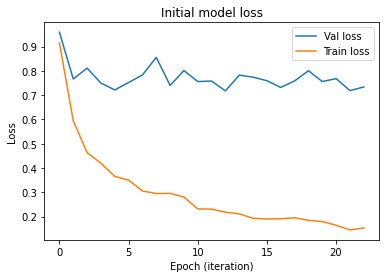

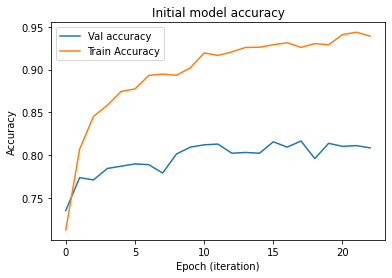

--------------------------------------------------------
it_history1.pkl
--------------------------------------------------------


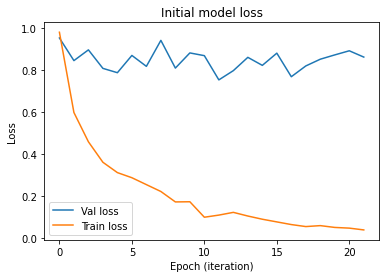

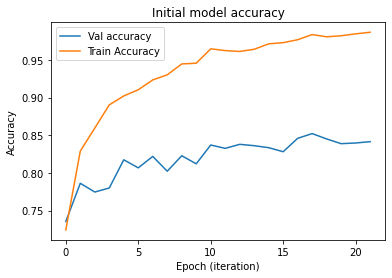

In [11]:
plot_it_history(history_it0, "it_history0.pkl")
plot_it_history(history_it1, "it_history1.pkl")

In [12]:


# Fine-tuning the model
model_name_it_0 = "garbage_classifier_mn_freez_it.h5"
model = tf.keras.models.load_model(model_name_it_0)
model.trainable = True

print("Fine-tuning model")
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft_0 = model.fit(train_generator, epochs=5, verbose = 1, \
                       callbacks= [early_stop, monitor_ft0, lr_schedule], \
                       validation_data = (validation_generator))

Fine-tuning model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 4)                 262148    
                                                                 
Total params: 3,491,012
Trainable params: 3,469,124
Non-trainable params: 21,888
_________________________________________________________________
None
Epoch 1/5


2022-04-03 13:44:56.752343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9317

2022-04-03 13:45:35.757142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


81/81 [==============================] - 48s 582ms/step - loss: 0.1866 - accuracy: 0.9317 - val_loss: 0.6895 - val_accuracy: 0.8068 - lr: 1.0000e-08
Epoch 2/5
81/81 [==============================] - 47s 574ms/step - loss: 0.1832 - accuracy: 0.9301 - val_loss: 0.7629 - val_accuracy: 0.8175 - lr: 1.0000e-08
Epoch 3/5
81/81 [==============================] - 47s 576ms/step - loss: 0.1739 - accuracy: 0.9315 - val_loss: 0.7317 - val_accuracy: 0.8148 - lr: 1.0000e-08
Epoch 4/5
81/81 [==============================] - 48s 586ms/step - loss: 0.1937 - accuracy: 0.9284 - val_loss: 0.7464 - val_accuracy: 0.7961 - lr: 1.0000e-08
Epoch 5/5
81/81 [==============================] - 47s 583ms/step - loss: 0.1947 - accuracy: 0.9309 - val_loss: 0.6960 - val_accuracy: 0.8085 - lr: 1.0000e-08


In [36]:
# history_ft0 = fine_tune_model("garbage_classifier_mn_freez_it.h5", monitor_ft0)
# history_ft1 = fine_tune_model("garbage_classifier_mn_ufreez_it.h5", monitor_ft1)


In [13]:
def plot_it_history(history_ft, ft_file_name):
    print("--------------------------------------------------------")
    print(ft_file_name)
    print("--------------------------------------------------------")

    plt.figure()
    plt.plot(history_ft.history["val_loss"], label = "Val loss")
    plt.plot(history_ft.history["loss"], label = "Train loss")
    plt.title('Fine-tuned model loss')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history_ft.history["val_accuracy"], label = "Val accuracy")
    plt.plot(history_ft.history["accuracy"], label = "Train Accuracy")
    plt.title('Fine-tuned model accuracy')
    plt.xlabel("Epoch (iteration)")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # ft_file = open("ft_history.pkl", "wb")
    ft_file = open(ft_file_name, "wb")
    pickle.dump(history_ft.history, ft_file)
    ft_file.close()

--------------------------------------------------------
ft_history_0.pkl
--------------------------------------------------------


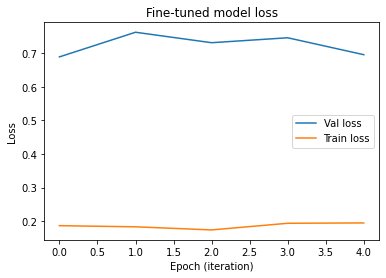

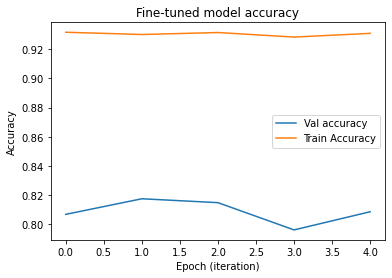

In [14]:
plot_it_history(history_ft_0, "ft_history_0.pkl")
# plot_it_history(history_ft2, "ft_history2.pkl")


In [15]:


test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

test_generator = train_gen.flow_from_directory(
    directory = "/Users/mac/Desktop/ENEL645/Final Project/Garbage-dataset-pre-processed/Test",
    target_size=(256, 256),
    color_mode="rgb",
    classes= class_names,
    class_mode="categorical",
    batch_size=bs,
    shuffle=True,
    seed=42,
    interpolation="nearest",
)

Found 807 images belonging to 4 classes.


In [16]:
def test_it_model(model_name_it):
    # Testing the model in the initial training
    model = tf.keras.models.load_model(model_name_it)
    model.evaluate(test_generator)
    metrics = model.evaluate(test_generator)
    print("Model Name", model.name)
    print("Categorical cross-entropy:", round(metrics[0], 3))
    print("Accuracy:", round(metrics[1]*100, 2),'%')
    
def test_ft_model(model_name_ft):
    # Testing the model in the fine tuning
    model = tf.keras.models.load_model(model_name_ft)
    model.evaluate(test_generator)
    metrics = model.evaluate(test_generator)
    print("Model Name", model.name)
    print("Categorical cross-entropy:", round(metrics[0], 3))
    print("Accuracy:", round(metrics[1]*100, 2),'%')

In [17]:
test_it_model("garbage_classifier_mn_freez_it.h5")
test_it_model("garbage_classifier_mn_ufreez_it.h5")
test_ft_model("garbage_classifier_mn_freez_ft.h5")
# test_ft_model("garbage_classifier_mn_ufreez_ft.h5")

2022-04-03 13:50:00.949866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 6s 453ms/step - loss: 0.7900 - accuracy: 0.7621
Model Name model
Categorical cross-entropy: 0.79
Accuracy: 76.21 %


2022-04-03 13:50:14.465889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 6s 462ms/step - loss: 1.0019 - accuracy: 0.7893
Model Name model_1
Categorical cross-entropy: 1.002
Accuracy: 78.93 %


2022-04-03 13:50:29.488527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 6s 457ms/step - loss: 0.7420 - accuracy: 0.7683
Model Name model
Categorical cross-entropy: 0.742
Accuracy: 76.83 %


2022-04-03 13:51:27.706569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Number of wrong predictions:  13


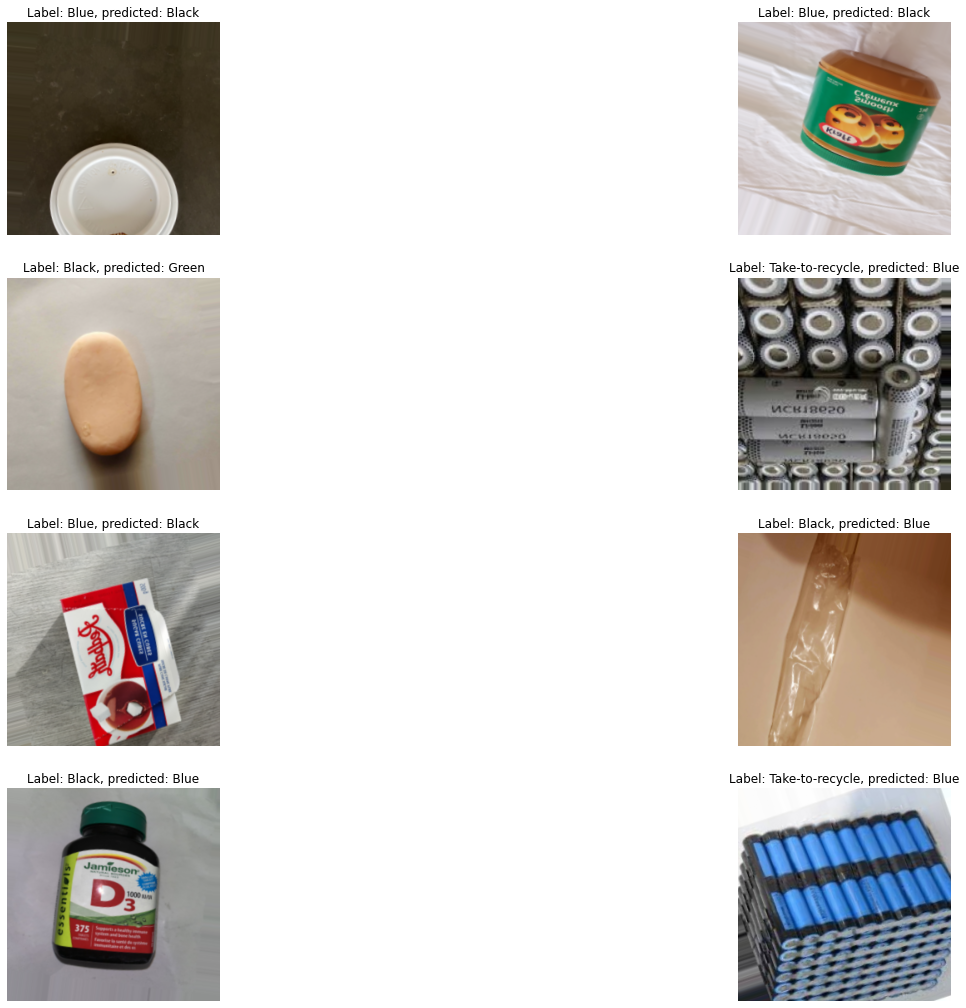

In [18]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model0.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

print("Number of wrong predictions: ", wrong_indexes.size)

sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

2022-04-03 13:51:34.971686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Number of wrong predictions:  9


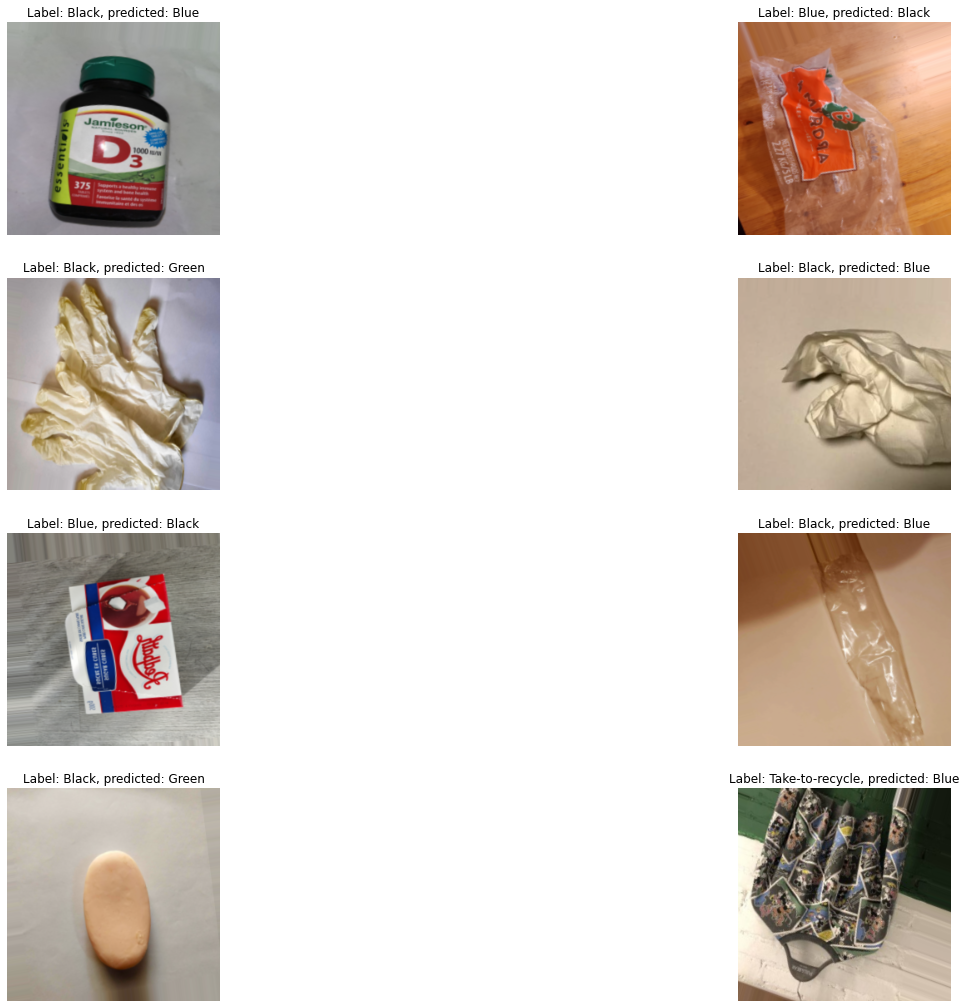

In [19]:
Xtest,Ytest = test_generator.__getitem__(0)
Ytest = Ytest.argmax(axis = 1) # get the label
Ypred = model1.predict(Xtest).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Ytest)[0]

print("Number of wrong predictions: ", wrong_indexes.size)

sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 8, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(4,2,ii+1)
    aux = Xtest[wrong_indexes[jj]]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %s" %(class_names[Ytest[wrong_indexes[jj]]],class_names[Ypred[wrong_indexes[jj]]]))
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import itertools

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
  
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(12, 12))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

def print_report_conf_matrix(model):
    print("--------------------------------------------------------")
    print(model.name)
    print("--------------------------------------------------------")
    Ypred = model.predict(Xtest).argmax(axis = 1)
    report = classification_report(Ytest, Ypred)
    print(report)
    plot_confusion_matrix_with_default_options(Ypred, Ytest, class_names)

--------------------------------------------------------
model
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.69      0.63        16
           1       0.67      0.59      0.62        17
           2       0.93      1.00      0.97        14
           3       1.00      0.88      0.94        17

    accuracy                           0.78        64
   macro avg       0.79      0.79      0.79        64
weighted avg       0.79      0.78      0.78        64

Confusion matrix, without normalization


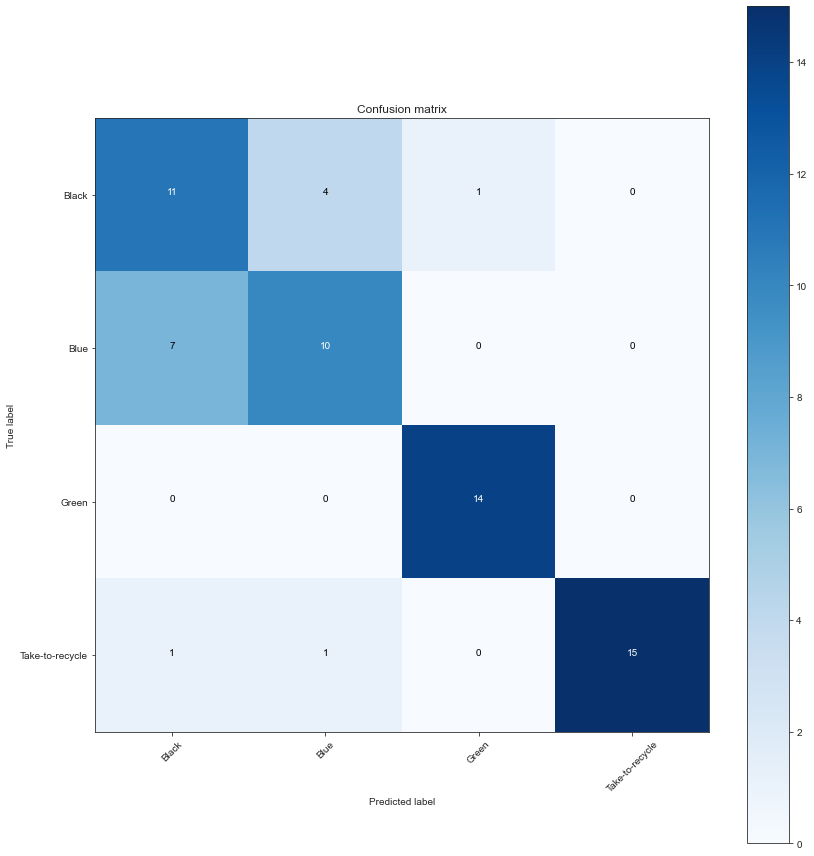

--------------------------------------------------------
model_1
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        16
           1       0.79      0.88      0.83        17
           2       0.88      1.00      0.93        14
           3       0.94      0.94      0.94        17

    accuracy                           0.86        64
   macro avg       0.86      0.86      0.86        64
weighted avg       0.86      0.86      0.85        64

Confusion matrix, without normalization


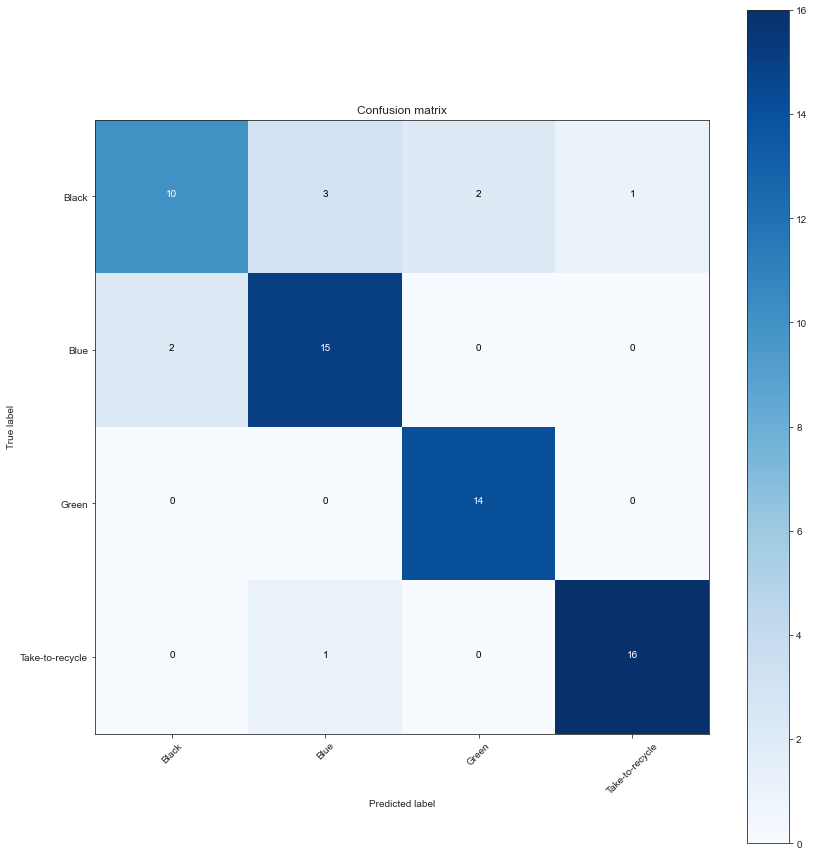

In [21]:
print_report_conf_matrix(model0)
print_report_conf_matrix(model1)
